Introduction and importing dependencies

In [97]:
!pip install --upgrade pip setuptools
!pip install tensorflow opencv-python matplotlib
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [98]:
pip install --upgrade opencv-python-headless

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [99]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

In [100]:
#importing tensor flow Dependencies - Functional API
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten


In [101]:
#Limiting GPU Memory consumption growth so we do not run into out of memory exeption/error
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.set_memory_growth(gpu, True)

#List of All available GPUs(Currently list of GPUs is empty because my laptop does not come with any built-in GPU)
gpus

[]

In [102]:
#Defining Folder Structures
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative') 
ANC_PATH = os.path.join('data','anchor')

In [103]:
# #Creating the required directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

Unpacking Labelled Faces, Collecting Anchor/ Positive Images

In [104]:
import uuid

In [105]:
# We establish a connection to the webcam
cap = cv2.VideoCapture(0)

# Looping through every single frame in the webcam
while cap.isOpened():   
    # Return value is boolean and tells us if the video capture device is working
    # Frame returns the current frame as an image
    ret, frame = cap.read()

    frame = frame[200:200+250, 500:500+250, :]

    #Collecting Anchors
    if cv2.waitKey(1) & 0xFF == ord('a'):
        #Creating unique name/filepath
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Write the anchor image to the path
        cv2.imwrite(imgname, frame)
    #Collecting Positives
    if cv2.waitKey(1) & 0xFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Write the anchor image to the path
        cv2.imwrite(imgname, frame)
        
    # Renders the returned frame in a window on the screen titled 'Image Captured'
    cv2.imshow('Image Captured', frame)
    
    # If the 'q' key is pressed then the system exits the current running window
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print("Exiting....")
        break
    
# Release the webcam
cap.release()
# Destroy the specific window
cv2.destroyWindow('Image Captured')
# Ensure all windows are closed
cv2.destroyAllWindows()
print("Webcam released and all related windows closed")

Exiting....
Webcam released and all related windows closed


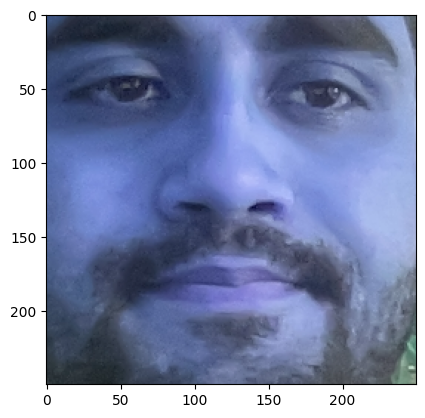

In [106]:
plt.imshow(frame)

In [158]:
#Fetching the image directories
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [159]:
ANC_PATH+'/*.jpg'

'data/anchor/*.jpg'

In [160]:
dir_test = anchor.as_numpy_iterator()

In [161]:
print(dir_test.next())

b'data/anchor/c7c8f2c4-1ea8-11ef-8d16-be8281faaadb.jpg'


In [162]:
#image preprocessing function
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img) #load in the image using the decode method
    #Preprocessing steps
    img = tf.image.resize(img, (100, 100))#resizing image to be 100pX100pX3channels
    img = img/255.0 #Normalization
    return img

In [112]:
img = preprocess('data/anchor/dc84ffdc-1ea8-11ef-8d16-be8281faaadb.jpg')

In [163]:
#Printing the scale of the darkest to the lightest pixel
#Usually min() = 0 because the darkest pixel is black
#max() value is the lightest pixel . Here there is no field of white so the vlaue is slightly less than 1
print(img.numpy().min())
print("to")
print(img.numpy().max())

0.0
to
0.9884804


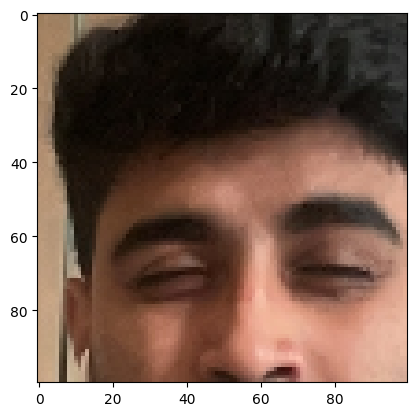

In [164]:
plt.imshow(img)

Creating Labelled Dataset

In [165]:
#(anchor, positive) => 1,1,1,1,1
#(anchor, negative) => 0,0,0,0,0

In [166]:
positives = tf.data.Dataset.zip(anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))
negatives = tf.data.Dataset.zip(anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))
data=positives.concatenate(negatives)

In [167]:
samples = data.as_numpy_iterator()

In [168]:
example = samples.next()

In [169]:
example

(b'data/anchor/4577b8fe-1e27-11ef-844f-be8281faaadb.jpg',
 b'data/positive/8001c820-1e27-11ef-844f-be8281faaadb.jpg',
 1.0)

Train test partitioning

In [170]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [171]:
res = preprocess_twin(*example)

In [172]:
res[0]

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.29387254, 0.25465685, 0.21936275],
        [0.3004902 , 0.26127452, 0.22598039],
        [0.29362744, 0.25441176, 0.21544118],
        ...,
        [0.3002451 , 0.29632354, 0.21789216],
        [0.29191175, 0.28799018, 0.20955883],
        [0.29436275, 0.28259805, 0.21593137]],

       [[0.32843137, 0.2872549 , 0.24607843],
        [0.3495098 , 0.30833334, 0.26127452],
        [0.37745097, 0.33848038, 0.2887255 ],
        ...,
        [0.28210783, 0.27622548, 0.20220588],
        [0.29387254, 0.28946078, 0.21911764],
        [0.29681373, 0.29289216, 0.22230393]],

       [[0.30490196, 0.25196078, 0.20784314],
        [0.360049  , 0.30857843, 0.25735295],
        [0.3129902 , 0.26813725, 0.2125    ],
        ...,
        [0.26544118, 0.25441176, 0.19362745],
        [0.27867648, 0.27132353, 0.20980392],
        [0.29289216, 0.2860294 , 0.22426471]],

       ...,

       [[0.8377451 , 0.7004902 , 0.48284313],
        [0.83

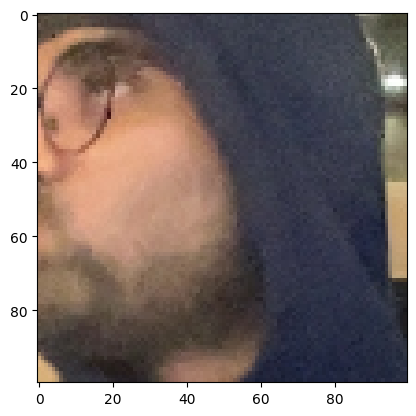

In [173]:
plt.imshow(res[0])

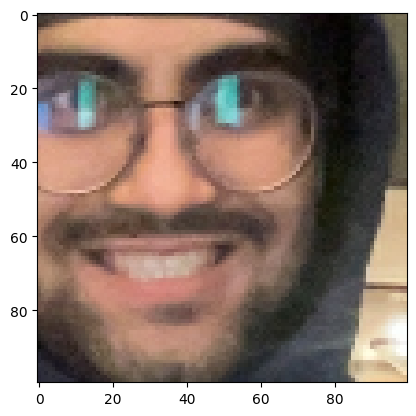

In [174]:
plt.imshow(res[1])

In [175]:
res[2]

1.0

In [176]:
#Building a data loader pipeline
data = data.map(preprocess_twin)
data = data.cache()
#Shuffling so that we do not have one type of images when we train and all the 3 classes of images appear random
data = data.shuffle(buffer_size=1024)

In [200]:
samples = data.as_numpy_iterator()

In [213]:
samp = samples.next()

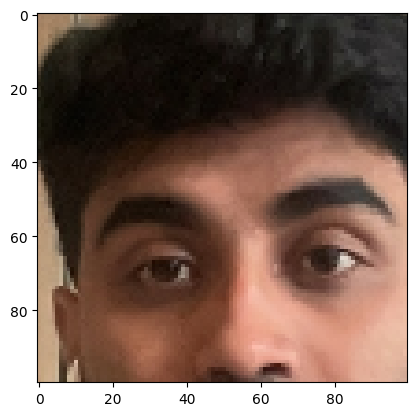

In [215]:
plt.imshow(samp[0])

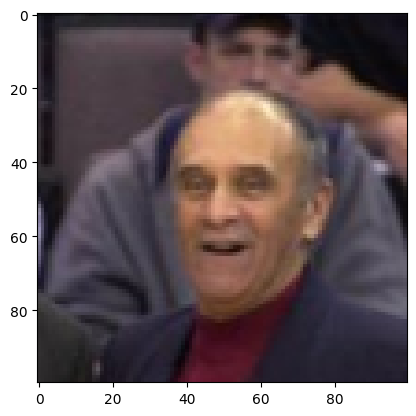

In [214]:
plt.imshow(samp[1])

In [216]:
samp[2]

0.0

Model Engineering